In [1]:
import numpy as np

import load_mnist
import plot_utils

/Users/inesalmeida/work/02901_DTU/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load Data

In [2]:
X_train, y_train = load_mnist.load_train()
X_val, y_val, X_test, y_test = load_mnist.split_val_test(load_mnist.load_test())

Loaded 60000 patterns with 784 features.
Loaded 10000 patterns with 784 features.


### Visualize some examples

In [3]:
%matplotlib inline

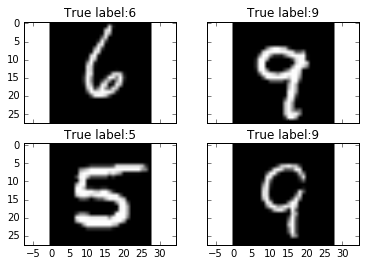

In [4]:
plot_utils.plot_a_few(X_train, y_train)

### Transform Data for ConvNet

In [5]:
from keras.utils import np_utils

Using Theano backend.


In [6]:
IMG_SIZE = 28
NUM_CLASSES = 10

def transform_Xy(X, y):
    X = X.reshape(X.shape[0], 1, IMG_SIZE, IMG_SIZE)
    X = X.astype('float32')
    X /= 255
    y = np_utils.to_categorical(y, NUM_CLASSES)
    return X, y

X_train, y_train = transform_Xy(X_train, y_train)
print X_train.shape, y_train.shape
X_val, y_val = transform_Xy(X_val, y_val)
X_test, y_test = transform_Xy(X_test, y_test)

(60000, 1, 28, 28) (60000, 10)


## Part 1: Basic Hyperparameter Estimation
We use a ConvNet. We want to estimate the most adequate dropout probabilities.

### Train a Basic ConvNet for Illustration

In [7]:
from conv_net import build_model

In [8]:
BATCH_SIZE = 10
NUM_EPOCHS = 12

# Build the model (ie the architecture)
model = build_model()

# Pick cost function, optimizer, metric
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=1, validation_data=(X_val, y_val))

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 189s - loss: 0.2528 - acc: 0.9232 - val_loss: 0.0614 - val_acc: 0.9830
Epoch 2/12
60000/60000 [==============================] - 188s - loss: 0.1166 - acc: 0.9658 - val_loss: 0.0437 - val_acc: 0.9885
Epoch 3/12
60000/60000 [==============================] - 188s - loss: 0.0944 - acc: 0.9721 - val_loss: 0.0412 - val_acc: 0.9875
Epoch 4/12
60000/60000 [==============================] - 191s - loss: 0.0837 - acc: 0.9758 - val_loss: 0.0352 - val_acc: 0.9900
Epoch 5/12
60000/60000 [==============================] - 193s - loss: 0.0774 - acc: 0.9780 - val_loss: 0.0314 - val_acc: 0.9895
Epoch 6/12
60000/60000 [==============================] - 191s - loss: 0.0736 - acc: 0.9788 - val_loss: 0.0359 - val_acc: 0.9900
Epoch 7/12
60000/60000 [==============================] - 192s - loss: 0.0701 - acc: 0.9798 - val_loss: 0.0278 - val_acc: 0.9900
Epoch 8/12
60000/60000 [========================

In [9]:
def score(model, X, y):
    s = model.evaluate(X, y, verbose=0)
    print 'Score:', s[0], 'Accuracy:', s[1]
    
print 'Train',
score(model, X_train, y_train)
print 'Validation',
score(model, X_val, y_val)
print 'Test',
score(model, X_test, y_test)

Train Score: 0.0364126349872 Accuracy: 0.989266666667
Validation Score: 0.0342757157688 Accuracy: 0.99
Test Score: 0.0441055048301 Accuracy: 0.9865


### 1D Bayesian Optimization Problem
By default, we pick p_drop = 0.25 for the second convolution layer. This value appeared from pure experience. The question is, could we find an adequate value using Bayesian Optimization?

We begin by defining our black-box function: f(p) = test_score(network_with_p_drop=p)

In [10]:
import GPyOpt

In [11]:
def f(p):
    m = build_model(p_drop3=p)
    
    # Pick cost function, optimizer, metric
    m.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
    print '.'
    # Train
    m.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=0, validation_data=(X_val, y_val))

    score = m.evaluate(X_test, y_test, verbose=0)
    
    # For progress tracking
    print 'x:', p, 'score:', score[0], 'test acc:', score[1]
    
    # Return the score on the test set
    return score[0]

In [12]:
# Define the problem bounds and budget
bounds = [{'name': 'p', 'type': 'continuous', 'domain': (0.1,0.9)}]

In [13]:
# Initialize the problem
np.random.seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                             initial_design_numdata=5,
                                             acquisition_type='EI',
                                             exact_feval = True)

.
x: [[ 0.65717535]] score: 0.0541110837428 test acc: 0.982875
.
x: [[ 0.32891147]] score: 0.0390837822897 test acc: 0.987375
.
x: [[ 0.28148116]] score: 0.0417027696933 test acc: 0.986875
.
x: [[ 0.54105182]] score: 0.0442964461339 test acc: 0.986
.
x: [[ 0.67557518]] score: 0.0843812745174 test acc: 0.97975


In [14]:
# Run the optimization
max_iter = 15       # evaluation budget
max_time = 21600    # time budget (6hrs)
eps      = 10e-6    # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps)  

.
x: [[ 0.32339083]] score: 0.0385058624361 test acc: 0.987625
.
x: [[ 0.3164077]] score: 0.0580367031373 test acc: 0.985125
.
x: [[ 0.32589895]] score: 0.0463769294636 test acc: 0.986375
.
x: [[ 0.33326903]] score: 0.0408138079889 test acc: 0.986875
.
x: [[ 0.27361241]] score: 0.0468255148092 test acc: 0.986625
.
x: [[ 0.28912505]] score: 0.0411026225443 test acc: 0.986875
.
x: [[ 0.55203158]] score: 0.0486940185738 test acc: 0.983875
.
x: [[ 0.53029525]] score: 0.04363668862 test acc: 0.986875
.
x: [[ 0.51941988]] score: 0.0536946801159 test acc: 0.983625
.
x: [[ 0.33057662]] score: 0.0388654179528 test acc: 0.98725


In [15]:
# Print the Optimum
print 'x_opt:', myBopt.x_opt
print 'f(x_opt):', myBopt.fx_opt

x_opt: [ 0.32339083]
f(x_opt): [ 0.03850586]


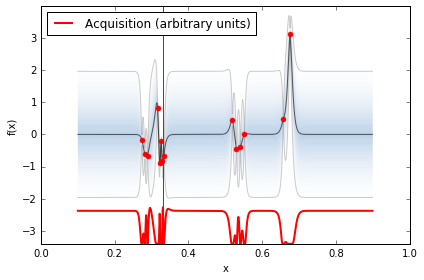

In [16]:
# Plot Expected Improvement
myBopt.plot_acquisition()

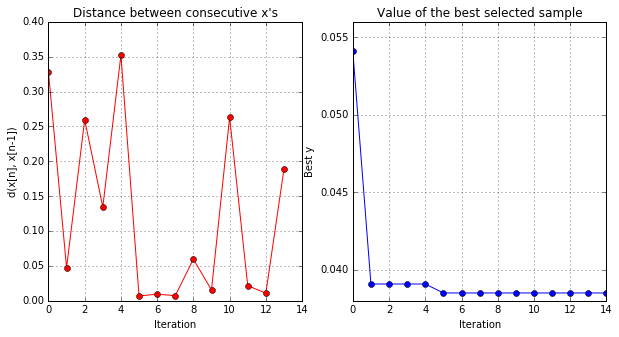

In [17]:
# Convergence
myBopt.plot_convergence()

### 2D Bayesian Optimization Problem
We now want to optimize two hyperparams: p_drop of the second convolutional layer, and p_drop of the (dense) hidden layer.

In [26]:
def f2(p):
    m = build_model(p_drop2=p[:, 0], p_drop3=p[:, 1])
    
    # Pick cost function, optimizer, metric
    m.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
    print '.'
    # Train
    m.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=0, validation_data=(X_val, y_val))

    score = m.evaluate(X_test, y_test, verbose=0)
    
    # For progress tracking
    print 'x:', p, 'score:', score[0], 'test acc:', score[1]
    
    # Return the score on the test set
    return score[0]

In [27]:
bounds2 =[{'name': 'p2', 'type': 'continuous', 'domain': (0.1, 0.9)},
         {'name': 'p3', 'type': 'continuous', 'domain': (0.1, 0.9)}]

In [28]:
# Initialize the problem
np.random.seed(123)
myBopt2D = GPyOpt.methods.BayesianOptimization(f2,
                                              domain=bounds2,
                                              model_type = 'GP',
                                              acquisition_type='EI',  # was LCB
                                              normalize_Y = True,
                                              acquisition_weight = 2)  

.
x: [[ 0.65717535  0.43848517]] score: 0.0506669195828 test acc: 0.9845
.
x: [[ 0.32891147  0.88461136]] score: 0.14173606912 test acc: 0.968875
.
x: [[ 0.28148116  0.64786379]] score: 0.0757991128401 test acc: 0.98175
.
x: [[ 0.54105182  0.48474552]] score: 0.0468650562172 test acc: 0.98475
.
x: [[ 0.67557518  0.41369401]] score: 0.0508116758099 test acc: 0.984875
The set cost function is ignored! LBC acquisition does not make sense with cost.


In [29]:
# runs the optimization for the three methods
max_iter = 40  # maximum time 40 iterations
max_time = 21600  # maximum time 60 seconds

myBopt2D.run_optimization(max_iter, max_time,verbosity=False)  

.
x: [[ 0.1  0.1]] score: 0.0375103984394 test acc: 0.98775
.
x: [[ 0.4760231  0.1      ]] score: 0.0409423683432 test acc: 0.98825
.
x: [[ 0.9  0.1]] score: 0.0628979614233 test acc: 0.97975
.
x: [[ 0.25049     0.31366607]] score: 0.0380300799668 test acc: 0.98725
.
x: [[ 0.1         0.37072037]] score: 0.0468397740202 test acc: 0.984625
.
x: [[ 0.27902809  0.1       ]] score: 0.0320073047457 test acc: 0.99
.
x: [[ 0.43903317  0.29247148]] score: 0.0365419702111 test acc: 0.986375
.
x: [[ 0.9         0.64580383]] score: 0.101938512227 test acc: 0.96875
.
x: [[ 0.31926037  0.19133032]] score: 0.0312642427208 test acc: 0.989625


In [30]:
# Print Optimum
print 'x_opt:', myBopt2D.x_opt
print 'f(x_opt):', myBopt2D.fx_opt

x_opt: [ 0.31926037  0.19133032]
f(x_opt): [ 0.03126424]


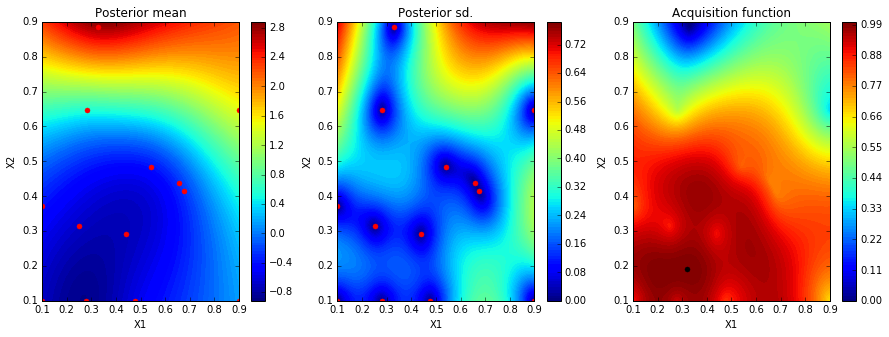

In [31]:
# Print LCB
myBopt2D.plot_acquisition()

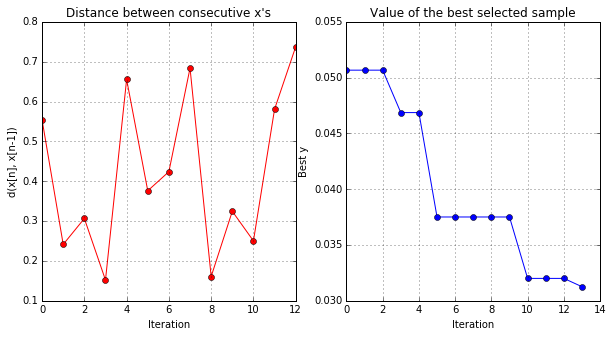

In [32]:
# Convergence
myBopt2D.plot_convergence()